In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


# Load the .h5ad file
adata = sc.read_h5ad("c2c0a633-136f-4c97-ab51-062ce97ad802.h5ad")
# Convert to DataFrame (genes as columns, cells as rows)
df = adata.to_df()

# Optionally, add metadata to the DataFrame
df.index = adata.obs.index  # Cell IDs
df.columns = adata.var.index  # Gene names

# Print the first few rows
#print(df.head())

df_metadata = adata.obs.copy()  # Cell metadata
df_gene_info = adata.var.copy()  # Gene metadata

# Show a summary
#print(df_metadata.head())
#print(df_gene_info.head())

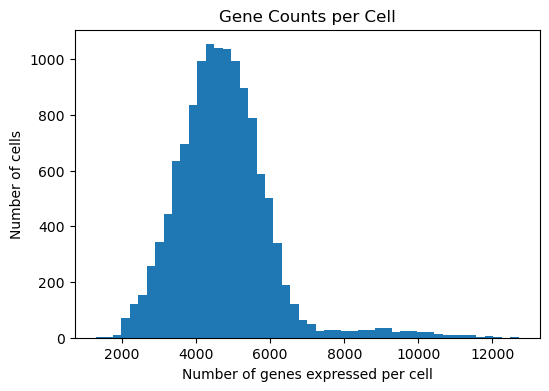

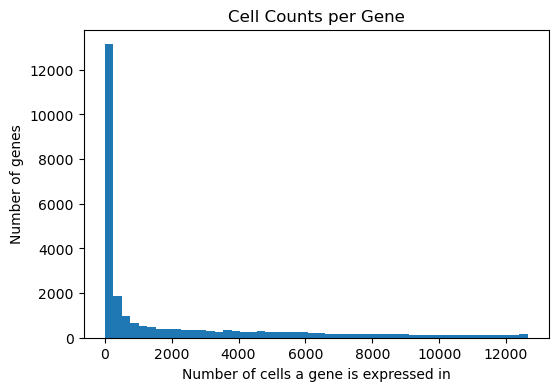

In [2]:
## Check the Distribution of Gene & Cell Counts

# Calculate number of expressed genes per cell
genes_per_cell = (df > 0).sum(axis=1)

# Calculate number of cells per gene
cells_per_gene = (df > 0).sum(axis=0)

# Plot distribution of genes per cell
plt.figure(figsize=(6, 4))
plt.hist(genes_per_cell, bins=50)
plt.xlabel("Number of genes expressed per cell")
plt.ylabel("Number of cells")
plt.title("Gene Counts per Cell")
plt.show()

# Plot distribution of cells per gene
plt.figure(figsize=(6, 4))
plt.hist(cells_per_gene, bins=50)
plt.xlabel("Number of cells a gene is expressed in")
plt.ylabel("Number of genes")
plt.title("Cell Counts per Gene")
plt.show()

In [3]:
# Normalize each cell to have 10,000 total counts
df_normalized = df.div(df.sum(axis=1), axis=0) * 1e4

# Log1p transformation (log(x + 1))
df_log = np.log1p(df_normalized)

# Show first rows
df_log.head()

,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000073953,ENSMUSG00000115784,ENSMUSG00000075161,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180213_sample_5-0,0.215454,0.375378,0.0,0.600212,0.0,0.0,0.0,1.232430,0.766168,0.760270,...,0.255448,0.828857,0.0,0.0,0.0,0.0,0.0,0.434453,0.0,0.0
20180215_sample_1-0,0.000000,0.000000,0.0,0.957568,0.0,0.0,0.0,0.285120,1.302807,0.518771,...,0.404736,0.031680,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180220_sample_1-0,0.236346,0.000000,0.0,0.483719,0.0,0.0,0.0,1.113181,0.304158,0.188440,...,0.000000,0.571100,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180225_sample_7-0,0.836066,0.004348,0.0,0.761593,0.0,0.0,0.0,0.495040,1.299329,0.134356,...,0.232265,0.636019,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180306_sample_1-0,0.000000,0.000000,0.0,0.662795,0.0,0.0,0.0,0.594921,0.178879,1.033845,...,0.302012,0.330564,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Explained variance by first 10 PCs: [0.05431874 0.02380748 0.01329129 0.01138441 0.01101792 0.01014167
 0.00802401 0.00595887 0.00521249 0.00394677]


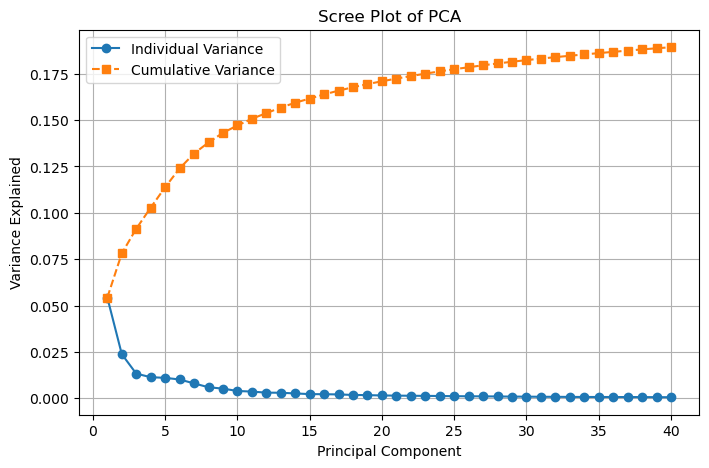

In [4]:
# Run PCA
pca = PCA(n_components=40)
pca_result = pca.fit_transform(df_log)

# Convert PCA result to a DataFrame
df_pca = pd.DataFrame(pca_result, index=df_log.index)

# Check variance explained by top PCs
explained_variance = pca.explained_variance_ratio_
print("Explained variance by first 10 PCs:", explained_variance[:10])

# Compute cumulative variance
cumulative_variance = np.cumsum(explained_variance[:50])

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 41), explained_variance[:40], marker="o", linestyle="-", label="Individual Variance")
plt.plot(range(1, 41), cumulative_variance[:40], marker="s", linestyle="--", label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot of PCA")
plt.legend()
plt.grid()
plt.show()

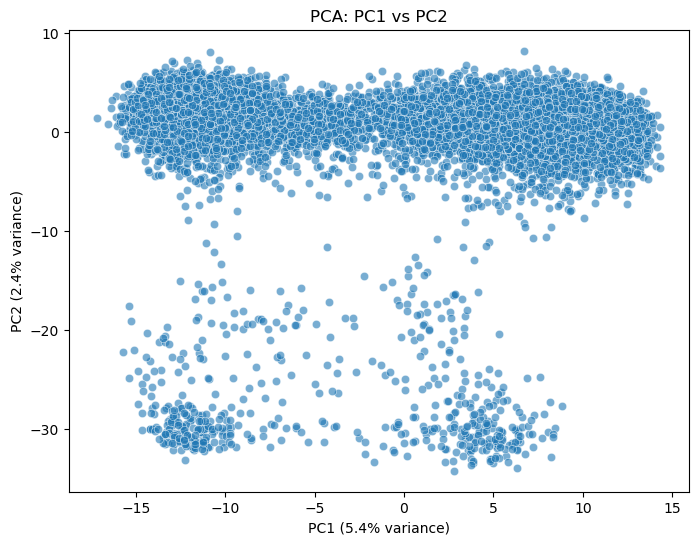

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca[0], y=df_pca[1], alpha=0.6)
plt.xlabel("PC1 (5.4% variance)")
plt.ylabel("PC2 (2.4% variance)")
plt.title("PCA: PC1 vs PC2")
plt.show()